# 项目：探索TMDB电影数据集调查

## 加载工具

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option("display.max_columns",0)


## 整理数据

In [2]:
# 加载数据集
def load_data():
    df = pd.read_csv("tmdb-movies.csv")
    return df
if __name__ == '__main__':
    df = load_data()

In [3]:
# 查看数据集的记录和属性的数量。分别是10866条和21个属性。
df.shape

(10866, 21)

In [4]:
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


>相关属性的介绍。暂时没有找到官方解释，手动翻译以下。
1. id 编号 
2. imdb_id IMDB编号 
3. popularity 在 Movie Database 上的相对页面查看次数
4. budget 预算，单位是美元
5. revenue 收入，单位是美元
6. original_title 电影名称
7. cast 主要演员，使用"|"进行分隔
8. homepage 电影网站
9. director 导演，使用"|"进行分隔
10. tagline 宣传口号
11. keywords 关键字
12. overview 简介
13. runtime 电影时长，单位是min
14. genres 电影类型，使用"|"进行分隔
15. production_companies 出品公司，使用"|"进行分隔
16. release_date 发行日期
17. vote_count 投票的数量
18. vote_average 投票的平均分
19. release_year 发行年份
20. budget_adj 调整后预算，调整inflation。数量级是10^8(亿元)，货币单位是美元
21. revenue_adj 调整后收入，调整inflation。数量是10^8(亿元)，货币单位是美元

>参考网站：https://zhuanlan.zhihu.com/p/48415482

In [5]:
#主要目的是查看每个属性的数据类型，以及数据类型是否与属性相一致。
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

1. 其次是看看每个属性是否存在null记录。
2. 从输出结果来看，存在null的记录。需要在后续进行处理。
3. released_date应该是datetime类型，release_year应该是datetime类型。

In [6]:
# 查看是否存在空值
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7930
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

+ 根据实际需要，处理存在null的记录。
+ 首先应该找到所有的属性都是null的记录，直接去除。
+ 如果需要分析主演与电影的关系，那么需要将cast字段缺失的记录去掉。
+ 电影是否有主页，与电影的评分等情况关系较小，没有主页的记录占总记录的比例超过50%，因此不能简单的进行去除空值记录。
+ 如果需要分析出品公司与电影的关系，需要将production_companies字段缺失的记录去掉。
+ 如果需要分析电影类型与电影评分的关系，需要将genres缺失的记录去掉。


In [7]:
# 查看是否存在重复的记录
df.duplicated().sum()

1

+ 对于重复记录，只有一条，删除处理。

+ 根据需要选择无关字段或者属性，并删除处理。
+ 综上，其中“overview”,"keywords","tagline"属于无关字段。
+ 另外，“budget”,"revenue"字段与“budget_adj”,"revenue_adj"选择一组即可，优先选择后者，因为不受物价水平影响。
+ “release_date”与“release_year”应该选择一个即可，如果没有必要详细到发型的日期，那么选择后者即可。
+ "vote_count"字段，与电影评分或者电影本身关系不大，只与投票人数有关或者总票数有关。
+ "popularity"字段，暂时保留，不确定这个字段的意义。

In [8]:
df.nunique()

id                      10865
imdb_id                 10855
popularity              10814
budget                    557
revenue                  4702
original_title          10571
cast                    10719
homepage                 2896
director                 5067
tagline                  7997
keywords                 8804
overview                10847
runtime                   247
genres                   2039
production_companies     7445
release_date             5909
vote_count               1289
vote_average               72
release_year               56
budget_adj               2614
revenue_adj              4840
dtype: int64

In [9]:
# 查看数值类型的字段的描述统计特征，判断是否存在异常值，
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


+ “id”字段，最小值是5，需要研究一下。
+ “popularity”字段，最大值是 32,而均值是 0.64，并且这个字段是否有存在的意义，也需要研究一下。
+ “budget”, "revenue" 字段中最小值是0，这个显然不合理，包括"budget_adj"和“revenue_adj”
+ "runtime"字段，最小值为0，这个显然不合理。那么电影时长的合理范围应该是多少？这个可能需要主观选择：至少60min。

### 疑问？
1. 如何找到彼此重复的记录。

## 数据清理

In [10]:
# 创建原数据集的副本，保留原数据集，做好备份。
df_copy = df.copy()
df_copy.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


### 删除重复的记录

In [11]:
df_copy.drop_duplicates(inplace = True)
# 查看去重的结果。
df_copy.duplicated().sum()

0

### 处理不需要的列，以及列名
- 参考 https://blog.csdn.net/moyue1002/article/details/80332186
- 其中提出了，id字段可以作为无用字段进行删除处理。

In [12]:
df_copy.columns

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [13]:
df_copy.drop(["overview","tagline","keywords","homepage","vote_count","release_date","revenue","budget","id"],axis =1 ,inplace = True)

In [14]:
df_copy.columns

Index(['imdb_id', 'popularity', 'original_title', 'cast', 'director',
       'runtime', 'genres', 'production_companies', 'vote_average',
       'release_year', 'budget_adj', 'revenue_adj'],
      dtype='object')

In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 12 columns):
imdb_id                 10855 non-null object
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              10865 non-null float64
revenue_adj             10865 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


In [16]:
#因为删除了重复的记录，因此index不连续，需要进行reset_index操作。
#同时，需要配合参数"drop"，默认为False，会掺入新的列。
df_copy.reset_index(drop=True,inplace = True)

In [17]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10865 entries, 0 to 10864
Data columns (total 12 columns):
imdb_id                 10855 non-null object
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              10865 non-null float64
revenue_adj             10865 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1018.7+ KB


### 处理空值

In [18]:
df_copy.isnull().sum()

imdb_id                   10
popularity                 0
original_title             0
cast                      76
director                  44
runtime                    0
genres                    23
production_companies    1030
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [19]:
df_copy.dropna(axis = 0,subset=['imdb_id','cast','director','genres','production_companies'],inplace = True)

In [20]:
df_copy.isnull().sum()

imdb_id                 0
popularity              0
original_title          0
cast                    0
director                0
runtime                 0
genres                  0
production_companies    0
vote_average            0
release_year            0
budget_adj              0
revenue_adj             0
dtype: int64

### 处理数据类型

In [21]:
df_copy.head(1)

,imdb_id,popularity,original_title,cast,director,runtime,genres,production_companies,vote_average,release_year,budget_adj,revenue_adj
0,tt0369610,32.985763,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6.5,2015,1.379999e+08,1.392446e+09


In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9770 entries, 0 to 10864
Data columns (total 12 columns):
imdb_id                 9770 non-null object
popularity              9770 non-null float64
original_title          9770 non-null object
cast                    9770 non-null object
director                9770 non-null object
runtime                 9770 non-null int64
genres                  9770 non-null object
production_companies    9770 non-null object
vote_average            9770 non-null float64
release_year            9770 non-null int64
budget_adj              9770 non-null float64
revenue_adj             9770 non-null float64
dtypes: float64(4), int64(2), object(6)
memory usage: 992.3+ KB


In [23]:
df_copy['runtime']= df_copy['runtime'].astype(float)

+ 将"release_year"的类型转换为datetime类型。

In [24]:
df_copy.release_year = pd.to_datetime(df_copy.release_year,format='%Y')

##### "df_copy.release_year= pd.to_datetime(df_copy.release_year,errors='raise',format="%d%m%Y")"
+ release_date属性中存在两个记录，其属性值是object类型，而不是int64类型，需要单独进行处理。

In [25]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9770 entries, 0 to 10864
Data columns (total 12 columns):
imdb_id                 9770 non-null object
popularity              9770 non-null float64
original_title          9770 non-null object
cast                    9770 non-null object
director                9770 non-null object
runtime                 9770 non-null float64
genres                  9770 non-null object
production_companies    9770 non-null object
vote_average            9770 non-null float64
release_year            9770 non-null datetime64[ns]
budget_adj              9770 non-null float64
revenue_adj             9770 non-null float64
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 992.3+ KB


In [26]:
df_copy.reset_index(drop = True,inplace=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9770 entries, 0 to 9769
Data columns (total 12 columns):
imdb_id                 9770 non-null object
popularity              9770 non-null float64
original_title          9770 non-null object
cast                    9770 non-null object
director                9770 non-null object
runtime                 9770 non-null float64
genres                  9770 non-null object
production_companies    9770 non-null object
vote_average            9770 non-null float64
release_year            9770 non-null datetime64[ns]
budget_adj              9770 non-null float64
revenue_adj             9770 non-null float64
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 916.0+ KB


### 处理异常值

In [27]:
df_copy.describe()

,popularity,runtime,vote_average,budget_adj,revenue_adj
count,9770.000000,9770.000000,9770.000000,9.770000e+03,9.770000e+03
mean,0.694775,102.939611,5.963388,1.941997e+07,5.706477e+07
std,1.037027,27.865500,0.913207,3.566891e+07,1.514632e+08
min,0.000188,0.000000,1.500000,0.000000e+00,0.000000e+00
25%,0.232619,90.000000,5.400000,0.000000e+00,0.000000e+00
50%,0.419762,100.000000,6.000000,3.179631e+05,0.000000e+00
75%,0.776465,112.000000,6.600000,2.467646e+07,4.312856e+07
max,32.985763,877.000000,8.700000,4.250000e+08,2.827124e+09


> #### 需要处理异常值的列，包括‘runtime’,'budget_adj','revenue_adj'
- 'runtime'表示电影的时长，因此最小值如果是0，显然不合理。
- ‘budget_adj’和‘revenue_adj’表示金额，因此如果最小值是0，显然不合理

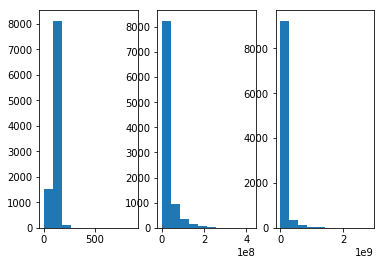

In [28]:
plt.subplot(1,3,1)
plt.hist(df_copy['runtime'])
plt.subplot(1,3,2)
plt.hist(df_copy['budget_adj'])
plt.subplot(1,3,3)
plt.hist(df_copy['revenue_adj'])
plt.show()

* 处理值为0的数据，删除处理。

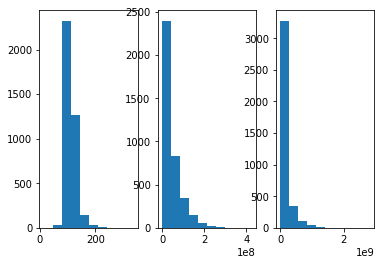

In [29]:
df_copy = df_copy[df_copy.runtime>0]
df_copy = df_copy[df_copy.budget_adj>0]
df_copy = df_copy[df_copy.revenue_adj>0]
plt.subplot(1,3,1)
plt.hist(df_copy['runtime'])
plt.subplot(1,3,2)
plt.hist(df_copy['budget_adj'])
plt.subplot(1,3,3)
plt.hist(df_copy['revenue_adj'])
plt.show()

### 需要解决的问题：
- 为了分析主演与电影评分的关系，需要将主演从‘cast’字段分离出来，需要创建多个新记录，每条记录中主演只有一个。
- 同理，导演与电影评分的关系，出品公司与电影评分的关系，或者统计票房多少。都需要对相应字段的中‘｜’进行分配，并创建新的记录。

In [30]:
df_copy.cast.str.contains("|",regex=False).value_counts()

True     3802
False       3
Name: cast, dtype: int64

In [31]:
df_copy.genres.str.contains('|',regex=False).value_counts()

True     3169
False     636
Name: genres, dtype: int64

In [32]:
df_copy.production_companies.str.contains('|',regex=False).value_counts()

True     2924
False     881
Name: production_companies, dtype: int64

In [33]:
new_production_corp = df_copy.production_companies.str.split('|',expand = True).stack()
new_production_corp = new_production_corp.reset_index(level=1,drop = True).rename('production_companies')
new_production_corp.head(10)

0             Universal Studios
0          Amblin Entertainment
0            Legendary Pictures
0       Fuji Television Network
0                        Dentsu
1     Village Roadshow Pictures
1    Kennedy Miller Productions
2          Summit Entertainment
2              Mandeville Films
2       Red Wagon Entertainment
Name: production_companies, dtype: object

In [34]:
new_genres = pd.Series(df_copy.genres.str.split('|',expand=True).stack())
new_genres = new_genres.reset_index(level = 1,drop = True).rename('genres')
new_genres.head(10)

0             Action
0          Adventure
0    Science Fiction
0           Thriller
1             Action
1          Adventure
1    Science Fiction
1           Thriller
2          Adventure
2    Science Fiction
Name: genres, dtype: object

In [35]:
new_cast = df_copy.cast.str.split('|',expand=True).stack()
new_cast = new_cast.reset_index(level = 1,drop = True).rename('cast')
new_cast.head(10)

0            Chris Pratt
0    Bryce Dallas Howard
0            Irrfan Khan
0      Vincent D'Onofrio
0          Nick Robinson
1              Tom Hardy
1        Charlize Theron
1       Hugh Keays-Byrne
1         Nicholas Hoult
1            Josh Helman
Name: cast, dtype: object

In [36]:
no_columns_cast_genres_prod_corp = df_copy.drop(['cast','genres','production_companies'],axis = 1)
no_columns_cast_genres_prod_corp.head()

,imdb_id,popularity,original_title,director,runtime,vote_average,release_year,budget_adj,revenue_adj
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09
1,tt1392190,28.419936,Mad Max: Fury Road,George Miller,120.0,7.1,2015-01-01,1.379999e+08,3.481613e+08
2,tt2908446,13.112507,Insurgent,Robert Schwentke,119.0,6.3,2015-01-01,1.012000e+08,2.716190e+08
3,tt2488496,11.173104,Star Wars: The Force Awakens,J.J. Abrams,136.0,7.5,2015-01-01,1.839999e+08,1.902723e+09
4,tt2820852,9.335014,Furious 7,James Wan,137.0,7.3,2015-01-01,1.747999e+08,1.385749e+09


In [37]:
df_with_new_cast = pd.concat([no_columns_cast_genres_prod_corp,new_cast],axis=1)
df_with_new_cast.head()

,imdb_id,popularity,original_title,director,runtime,vote_average,release_year,budget_adj,revenue_adj,cast
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Chris Pratt
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Bryce Dallas Howard
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Irrfan Khan
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Vincent D'Onofrio
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Nick Robinson


In [38]:
df_with_new_genres = pd.concat([no_columns_cast_genres_prod_corp,new_genres],axis =1)
df_with_new_genres.head()

,imdb_id,popularity,original_title,director,runtime,vote_average,release_year,budget_adj,revenue_adj,genres
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Action
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Adventure
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Science Fiction
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Thriller
1,tt1392190,28.419936,Mad Max: Fury Road,George Miller,120.0,7.1,2015-01-01,1.379999e+08,3.481613e+08,Action


In [39]:
df_with_new_production_corp = pd.concat([no_columns_cast_genres_prod_corp,new_production_corp],axis=1)
df_with_new_production_corp.head()

,imdb_id,popularity,original_title,director,runtime,vote_average,release_year,budget_adj,revenue_adj,production_companies
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Universal Studios
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Amblin Entertainment
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Legendary Pictures
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Fuji Television Network
0,tt0369610,32.985763,Jurassic World,Colin Trevorrow,124.0,6.5,2015-01-01,1.379999e+08,1.392446e+09,Dentsu


#### 遗留的问题：
- 无法将'df_with_new_cast','df_with_new_genres','df_with_new_production_corp'三个DataFrame合成一个。

In [40]:
# df_with_new_cast.merge(df_with_new_genres,how ='inner',left_on='imdb_id',right_on='imdb_id')

In [41]:
# temp_columns = df_copy[df_copy.cast.str.contains('|',regex=False]
# df1 = temp_cast.copy()
# df2 = temp_cast.copy()
# df3 = temp_cast.copy()
# df4 = temp_cast.copy()
# df5 = temp_cast.copy()

> 需要回答的问题？
> + 那些演员主演的电影的平均评分较高？
> + 那些电影公司出品的电影的平均评分较高？
> + 那些类型的电影的平均评分较高？
> + 评分与电影的投资金额是否具有相关性？
> + 评分与电影的票房收入是否具有相关性？

相关性问题探索：
> 1. 评分与电影投资金额
> 2. 评分高，是否票房收入高？

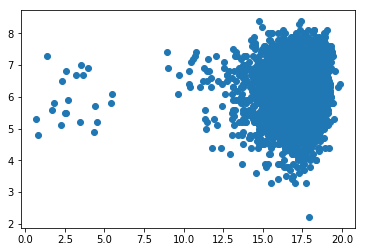

In [42]:
plt.scatter(np.log(df_copy.budget_adj+1),df_copy.vote_average)
plt.show()

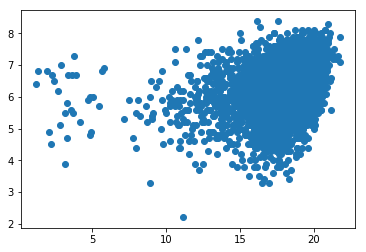

In [43]:
plt.scatter(np.log(df_copy.revenue_adj+1),df_copy.vote_average)
plt.show()

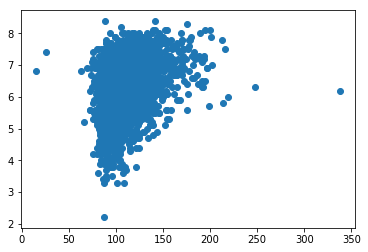

In [44]:
plt.scatter(df_copy.runtime,df_copy.vote_average)

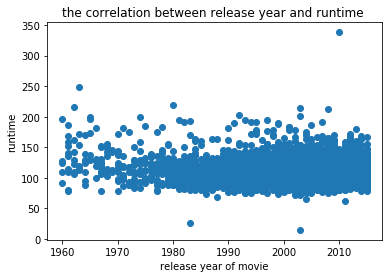

In [45]:
plt.scatter(df_copy.release_year.dt.year,df_copy.runtime)
plt.xlabel('release year of movie')
plt.ylabel('runtime')
plt.title('the correlation between release year and runtime ')
plt.show()

分组问题探索：
> 1. 那些演员主演的电影的平均评分较高？
> 2. 那些电影公司出品的电影的平均评分较高？
> 3. 那些类型的电影的平均评分较高？

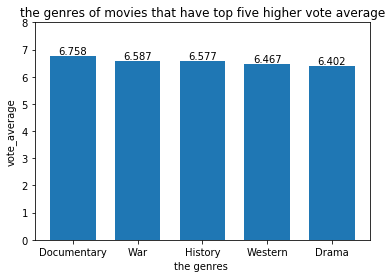

In [46]:
genres_vote_average = df_with_new_genres.groupby('genres').vote_average.mean().sort_values(ascending=False)
x = genres_vote_average.index[:5]
y = genres_vote_average.values[:5]
plt.bar(x,height =y,width = 0.7)
plt.title('the genres of movies that have top five higher vote average')
plt.xlabel('the genres ')
plt.ylabel('vote_average')
plt.ylim(0,8)
for a,b in zip(x,y):
    plt.text(a,b,'%.3f'%b,ha = 'center',va = 'bottom',fontsize=10)
plt.show()

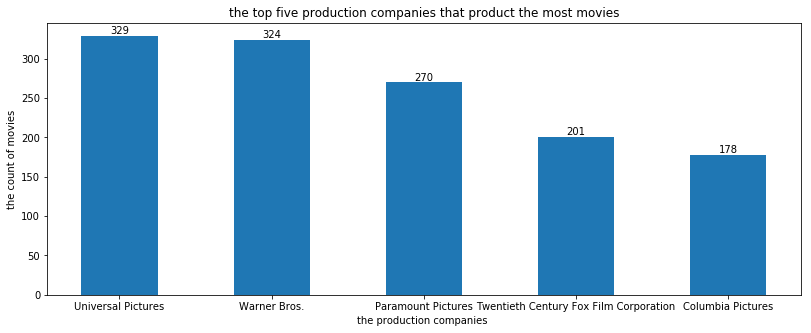

In [47]:
prod_corp_vote_average = df_with_new_production_corp.groupby('production_companies').vote_average.mean().sort_values(ascending= False)
# prod_corp_vote_average.head()
prod_corp_counts = df_with_new_production_corp.groupby('production_companies').imdb_id.count().sort_values(ascending=False)
# prod_corp_counts.head()
fg = plt.figure(figsize=(13.5,5.0))
x = prod_corp_counts.index[:5]
y = prod_corp_counts.values[:5]
plt.bar(x,height =y,width = 0.5)
plt.title('the top five production companies that product the most movies')
plt.xlabel('the production companies ')
plt.ylabel('the count of movies')
for a,b in zip(x,y):
    plt.text(a,b,'%.0f'%b,ha = 'center',va = 'bottom',fontsize=10)
plt.show()

In [48]:
cast_vote_average = df_with_new_cast.groupby('cast').vote_average.mean().sort_values(ascending =False)
cast_vote_average.head()

cast
David Byrne       8.4
Jerry Harrison    8.4
Tina Weymouth     8.4
Steven Scales     8.4
Chris Frantz      8.4
Name: vote_average, dtype: float64